In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow_datasets as tfds
import tensorflow as tf
import tensorflow.keras.layers as layers

import time
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.0.0-rc1


In [2]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True, as_supervised=True)

In [3]:
train_examples, val_examples = examples['train'], examples['validation']

In [4]:
tokenizer_en = tfds.features.text.SubwordTextEncoder.build_from_corpus(
(en.numpy() for pt, en in train_examples), target_vocab_size=2**13)
tokenizer_pt = tfds.features.text.SubwordTextEncoder.build_from_corpus(
(pt.numpy() for pt, en in train_examples), target_vocab_size=2**13)

In [5]:
sample_str = 'hello world, tensorflow 2'
tokenized_str = tokenizer_en.encode(sample_str)
print(tokenized_str)
original_str = tokenizer_en.decode(tokenized_str)
print(original_str)

[3222, 439, 150, 7345, 1378, 2824, 2370, 7881]
hello world, tensorflow 2


In [6]:
def encode(lang1, lang2):
    lang1 = [tokenizer_pt.vocab_size] + tokenizer_pt.encode(
        lang1.numpy()) + [tokenizer_pt.vocab_size+1]
    lang2 = [tokenizer_en.vocab_size] + tokenizer_en.encode(
        lang2.numpy()) + [tokenizer_en.vocab_size+1]
    return lang1, lang2

In [7]:
MAX_LENGTH=40
def filter_long_sent(x, y, max_length=MAX_LENGTH):
    return tf.logical_and(tf.size(x) <= max_length,
                         tf.size(y) <= max_length)

将python运算，转换为tensorflow运算节点

In [8]:
def tf_encode(pt, en):
    return tf.py_function(encode, [pt, en], [tf.int64, tf.int64])

In [9]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

# 使用.map()运行相关图操作
train_dataset = train_examples.map(tf_encode)
# 过滤过长的数据
train_dataset = train_dataset.filter(filter_long_sent)
# 使用缓存数据加速读入
train_dataset = train_dataset.cache()
# 打乱并获取批数据
train_dataset = train_dataset.padded_batch(
BATCH_SIZE, padded_shapes=([40], [40]))  # 填充为最大长度-90
# 设置预取数据
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

# 验证集数据
val_dataset = val_examples.map(tf_encode)
val_dataset = val_dataset.filter(filter_long_sent).padded_batch(
BATCH_SIZE, padded_shapes=([40], [40]))

In [10]:
de_batch, en_batch = next(iter(train_dataset))
de_batch, en_batch

(<tf.Tensor: id=207655, shape=(64, 40), dtype=int64, numpy=
 array([[8214,    7,  261, ...,    0,    0,    0],
        [8214,  116,   84, ...,    0,    0,    0],
        [8214,  155,   39, ...,    0,    0,    0],
        ...,
        [8214,  639,  590, ...,    0,    0,    0],
        [8214,  204, 3441, ...,    0,    0,    0],
        [8214,   27,   13, ...,    0,    0,    0]])>,
 <tf.Tensor: id=207656, shape=(64, 40), dtype=int64, numpy=
 array([[8087, 4670, 1783, ...,    0,    0,    0],
        [8087,   83,  145, ...,    0,    0,    0],
        [8087,  169,   56, ...,    0,    0,    0],
        ...,
        [8087,  174,   79, ...,    0,    0,    0],
        [8087,   11,   16, ...,    0,    0,    0],
        [8087,    4,   12, ...,    0,    0,    0]])>)

In [28]:
def get_angles(pos, i, d_model):
    # 这里的i等价与上面公式中的2i和2i+1
    angle_rates = 1 / np.power(10000, (2*(i // 2))/ np.float32(d_model))
    return pos * angle_rates

In [29]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                           np.arange(d_model)[np.newaxis,:],
                           d_model)
    # 第2i项使用sin
    sines = np.sin(angle_rads[:, 0::2])
    # 第2i+1项使用cos
    cones = np.cos(angle_rads[:, 1::2])
    pos_encoding = np.concatenate([sines, cones], axis=-1)
    pos_encoding = pos_encoding[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


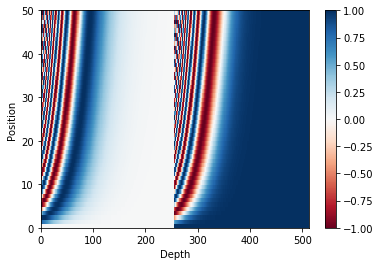

In [30]:
pos_encoding = positional_encoding(50, 512)
print(pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show() # 在这里左右边分别为原来2i 和 2i+1的特征

论文推荐的position embedding

In [25]:
def gen_pos_emb_ele(pos, i, d_model):
    res =np.where(i%2==0,np.cos(pos / np.power(10000, i/ np.float32(d_model))),
                          np.sin(pos / np.power(10000, (i-1)/ np.float32(d_model))))
    return res

def pos_emb(max_len,d_model):
    p=get_pos_emb(np.arange(max_len)[:, np.newaxis], np.arange(d_model)[np.newaxis,:], d_model)
    return tf.cast(p[np.newaxis, ...], dtype=tf.float32)

(1, 50, 512)


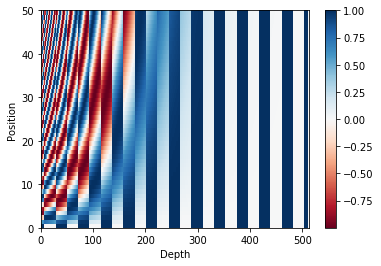

In [31]:
p=pos_emb(50,512)
print(p.shape)

plt.pcolormesh(p[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [32]:
def create_padding_mark(seq):
    # 获取为0的padding项
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    
    # 扩充维度以便用于attention矩阵
    return seq[:, np.newaxis, np.newaxis, :] # (batch_size,1,1,seq_len)

# mark 测试
create_padding_mark([[1,2,0,0,3],[3,4,5,0,0]])

<tf.Tensor: id=207998, shape=(2, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]]], dtype=float32)>

In [33]:
def scaled_dot_product_attention(q, k, v, mask):
    # query key 相乘获取匹配关系
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    
    # 使用dk进行缩放
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    
    # 掩码
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)
        
    # 通过softmax获取attention权重
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    
    # attention 乘上value
    output = tf.matmul(attention_weights, v) # （.., seq_len_v, depth）
    
    return output, attention_weights

In [48]:
def print_out(q, k, v):
    temp_out, temp_att = scaled_dot_product_attention(q, k, v, None)
    print('attention weight:')
    print(temp_att)
    print('output:')
    print(temp_out)
    print("show attention weight:")
    plt.pcolormesh(temp_att, cmap='RdBu')
    plt.xlabel('K')
    plt.ylabel('Q')
    plt.xlim(0,4)              #设置x,y的区间
    plt.ylim(0,3)
    plt.xticks([0,1,2,3,4])
    plt.yticks([0,1,2,3])
    plt.grid(linestyle='-.')
    plt.colorbar()
    plt.show()

attention weight:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
output:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)
show attention weight:


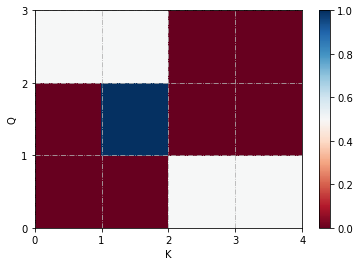

In [49]:
# 显示为numpy类型
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[1,0],
                      [10,0],
                      [100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)
temp_q = tf.constant([[0,0,10], 
                      [0,10,0], 
                      [10,10,0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)